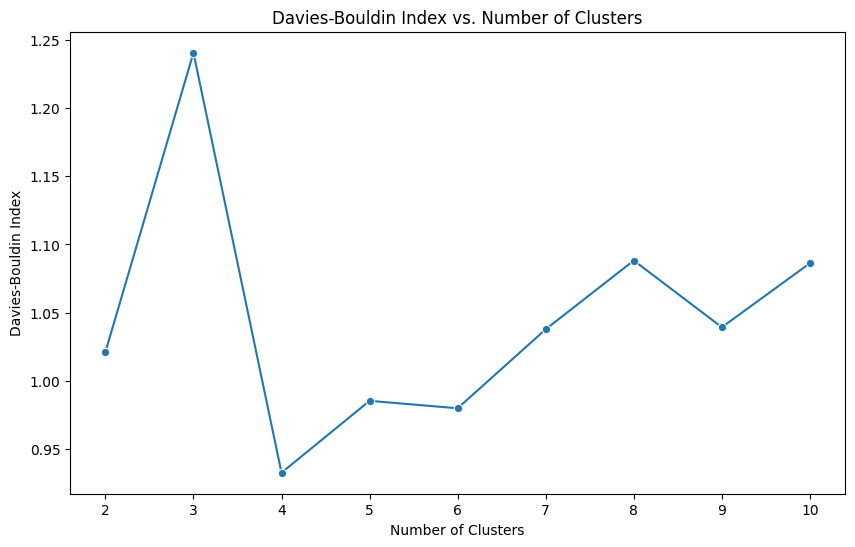

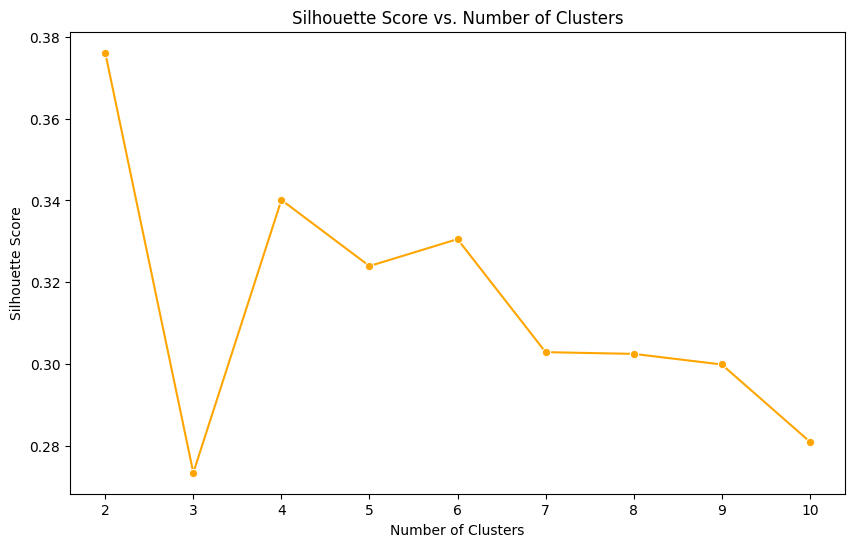

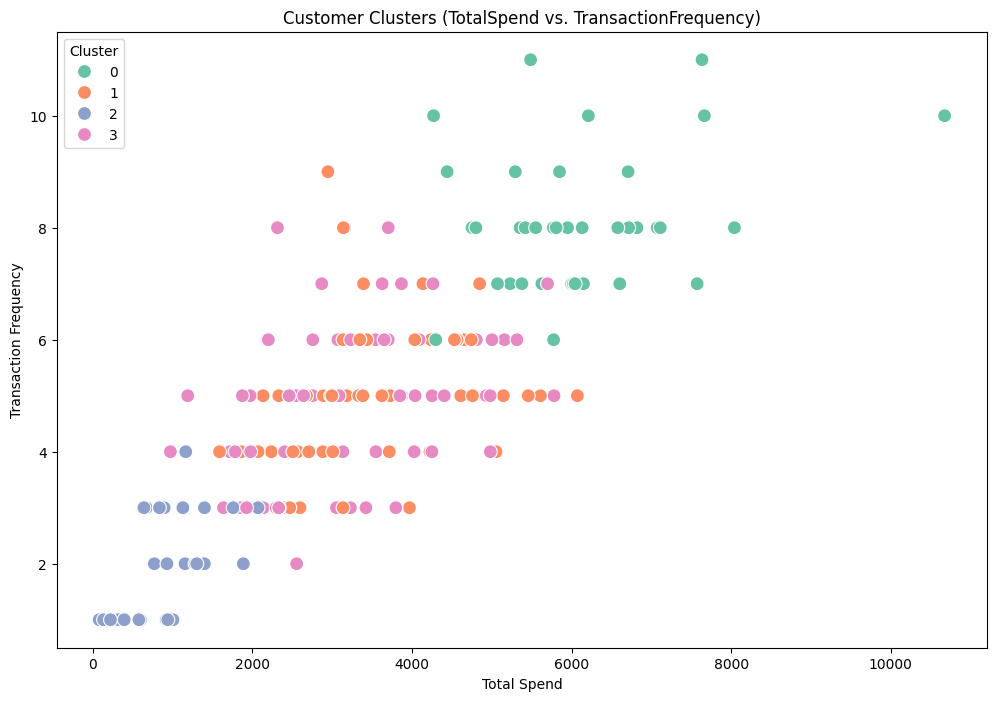

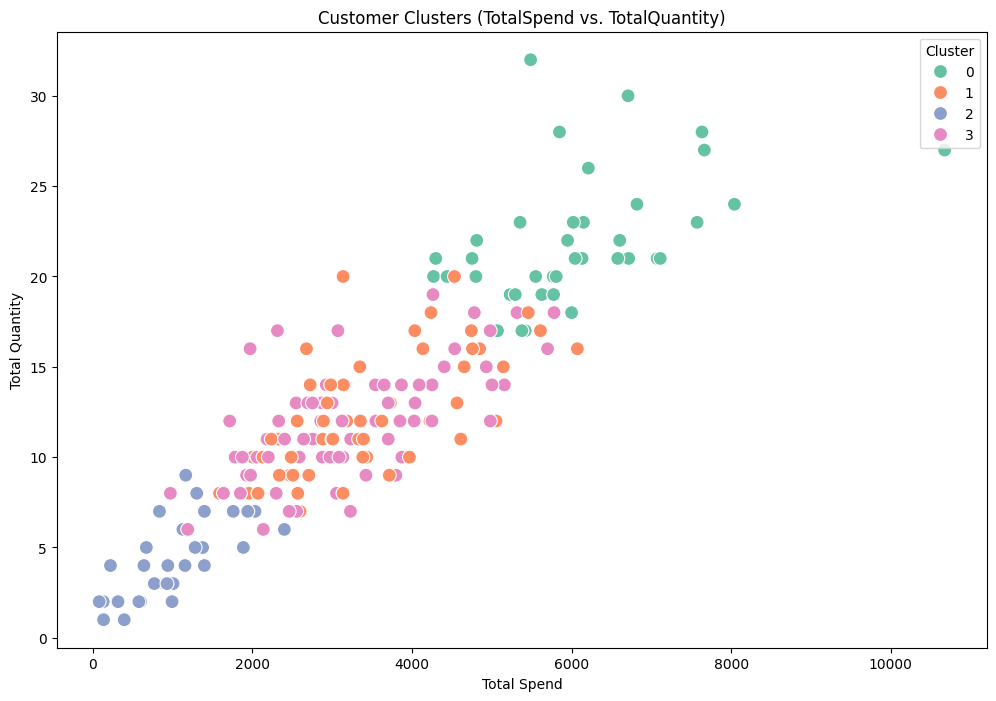

Optimal Number of Clusters: 4
Final Davies-Bouldin Index: 0.9323856143044559
Final Silhouette Score: 0.3401263953062617


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")
products_df = pd.read_csv("Products.csv")

# Merge Customers with Transactions
customer_transactions = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

# Merge the above with Products
merged_data = pd.merge(customer_transactions, products_df, on="ProductID", how="inner")

# Extract key features for clustering
clustering_data = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",           # Total spend by customer
    "TransactionID": "count",     # Number of transactions (frequency)
    "Quantity": "sum"             # Total quantity purchased
}).rename(columns={
    "TotalValue": "TotalSpend",
    "TransactionID": "TransactionFrequency",
    "Quantity": "TotalQuantity"
})

# Add Region Encoding
region_mapping = {region: idx for idx, region in enumerate(customers_df["Region"].unique())}
customers_df["RegionEncoded"] = customers_df["Region"].map(region_mapping)
clustering_data = clustering_data.merge(customers_df[["CustomerID", "RegionEncoded"]], on="CustomerID", how="left")

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data[["TotalSpend", "TransactionFrequency", "TotalQuantity", "RegionEncoded"]])

# Determine the optimal number of clusters
db_indices = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    labels = kmeans.labels_
    db_indices.append(davies_bouldin_score(scaled_data, labels))
    silhouette_scores.append(silhouette_score(scaled_data, labels))

optimal_k = cluster_range[db_indices.index(min(db_indices))]

# Final K-Means clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clustering_data["Cluster"] = final_kmeans.fit_predict(scaled_data)

# Visualizations
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(cluster_range), y=db_indices, marker="o")
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=list(cluster_range), y=silhouette_scores, marker="o", color="orange")
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=clustering_data,
    x="TotalSpend",
    y="TransactionFrequency",
    hue="Cluster",
    palette="Set2",
    s=100
)
plt.title("Customer Clusters (TotalSpend vs. TransactionFrequency)")
plt.xlabel("Total Spend")
plt.ylabel("Transaction Frequency")
plt.legend(title="Cluster")
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=clustering_data,
    x="TotalSpend",
    y="TotalQuantity",
    hue="Cluster",
    palette="Set2",
    s=100
)
plt.title("Customer Clusters (TotalSpend vs. TotalQuantity)")
plt.xlabel("Total Spend")
plt.ylabel("Total Quantity")
plt.legend(title="Cluster")
plt.show()

# Final Metrics
final_db_index = davies_bouldin_score(scaled_data, clustering_data["Cluster"])
final_silhouette = silhouette_score(scaled_data, clustering_data["Cluster"])

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Final Davies-Bouldin Index: {final_db_index}")
print(f"Final Silhouette Score: {final_silhouette}")
